In [1]:
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
import os
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

In [5]:
llm.invoke("hi hello how are you?")

AIMessage(content="Hello! I'm just a computer program, so I don't have feelings, but I'm here to help you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 13, 'total_tokens': 41, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-Bn1gcfk7Vu6Zd3qeyk44zE4yHjSN5', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--344d263c-28bd-4bba-a3e9-cb0d48af33ed-0', usage_metadata={'input_tokens': 13, 'output_tokens': 28, 'total_tokens': 41, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
from langgraph.types import Command

In [7]:
from langgraph.prebuilt import create_react_agent

In [ ]:
# class AgentState(TypedDict):
#     messages: Annotated[Sequence[BaseMessage], add_messages]
#     Name:str
#     age:int
#     DOB:int

Command is a class with 2 important parameters:
 - goto: which agent we need to go to
 - update : what updates we need to take

In [12]:
def add_number(state):
    result=state["num1"]+state["num2"]
    print(f"addition is {result}")
    return Command(goto="multiply",update={"sum":result})


In [15]:
state={"num1":10,"num2":20}

In [16]:
add_number(state)

addition is 30


Command(update={'sum': 30}, goto='multiply')

### Creating one dummy multiagent

it is for network/collab multiagent

In [17]:
from langchain_core.tools import tool

In [39]:
# dummy tool
@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help"""
    return

In [40]:
# dummy tool
@tool
def transfer_to_addition_expert():
    """Ask addition agent for help"""
    return

In [35]:
llm_with_tool=llm.bind_tools([transfer_to_addition_expert])

In [22]:
response=llm_with_tool.invoke("hi")

In [23]:
response.content

'Hello! How can I assist you today?'

observe response is coming from llm

In [24]:
response.tool_calls

[]

observe tool is not called

In [25]:
response=llm_with_tool.invoke("what is 2+2?")

In [26]:
response.content

''

In [27]:
response.tool_calls

[{'name': 'transfer_to_addition_expert',
  'args': {},
  'id': 'call_elPh3Xs92JpN23kK8isAUSto',
  'type': 'tool_call'}]

observe now llm is not providing any response insted this task is done through tool call


observe now llm is not providing any response insted this task is done through tool call


In [34]:
system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )

In [35]:
messages = [{"role": "system", "content": system_prompt}] + ["can you tell me the addition of 2 and 2?"]

In [36]:
messages

[{'role': 'system',
  'content': 'You are an addition expert, you can ask the multiplication expert for help with multiplication.Always do your portion of calculation before the handoff.'},
 'can you tell me the addition of 2 and 2?']

[{'role': 'system',
  'content': 'You are an addition expert, you can ask the multiplication expert for help with multiplication.Always do your portion of calculation before the handoff.'},
 'can you tell me the addition of 2 and 2?']

In [41]:
from typing_extensions import Literal
from langgraph.graph import MessagesState,StateGraph, START,END

In [51]:
### Agent1
def additional_expert(state:MessagesState)-> Command[Literal["multiplication_expert", "__end__"]]:
    
    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    
    ai_msg = llm.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred to multiplication expert",
            "tool_call_id": tool_call_id,
        }
        
        return Command(
            goto="multiplication_expert", update={"messages": [ai_msg, tool_msg]}
        )
    return {"messages": [ai_msg]}

In [52]:
##Agent2
def multiplication_expert(state:MessagesState)-> Command[Literal["additional_expert", "__end__"]]:
    
    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = llm.bind_tools([transfer_to_addition_expert]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred to addition expert",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="additional_expert", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [57]:
graph=StateGraph(MessagesState)

In [58]:
graph.add_node("additional_expert",additional_expert)
graph.add_node("multiplication_expert",multiplication_expert)

In [59]:
graph.add_edge(START, "additional_expert")

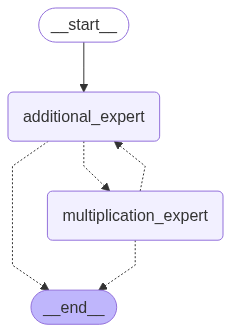

In [60]:
graph.compile()

In [61]:
app=graph.compile()

In [62]:
app.invoke({"messages":[("user","what's (3 + 5) * 12. Provide me the output")]})

{'messages': [HumanMessage(content="what's (3 + 5) * 12. Provide me the output", additional_kwargs={}, response_metadata={}, id='369256eb-d105-4a93-a845-f961c3403d89'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_r6OhV1jBFBqa72mupaZtLBeK', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 86, 'total_tokens': 119, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-Bn3IhWdLT5xvjhodHUVSCdOMsTfp4', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--72c28e00-8284-4c98-87f6-692b1d4782a2-0', tool_calls=[{'name': 'transfer_to_multiplication_expert', 

## With realtime tool

In [65]:
from langchain_community.tools import DuckDuckGoSearchRun

In [67]:
search_tool=DuckDuckGoSearchRun()

# import os
# from langchain_community.tools.tavily_search import TavilySearchResults
# TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
# search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

In [68]:
search_tool.invoke("who is a current pm of uk?")

"British Prime Minister Keir Starmer delivers a speech following his first Cabinet meeting as Prime Minister, in London, July 6, 2024. Mr Starmer has been leader of the Labour party since 2020 and is the country's 58th prime minister. He was born in 1962. His dad was a toolmaker in a factory and his mum was a nurse in the NHS. Keir Starmer, a human rights lawyer from a small town in southern England, is the new prime minister of the United Kingdom. His victory on July 4 was overwhelming. Yet Britain barely knows who he is. Starmer has been a politician for only nine years, and since being crowned U.K. Labour leader in 2020 has steered his party from its worst ... Sir Keir Starmer became Prime Minister on 5 July 2024. Education Keir attended Reigate Grammar School, before studying Law at the University of Leeds. He went on to do postgraduate studies at the ... Keir Starmer's tenure as Prime Minister of the United Kingdom began on 5 July 2024 when he accepted an invitation from King Char

In [69]:
from langchain_experimental.utilities import PythonREPL

In [70]:
repl=PythonREPL()

In [71]:
code = """
x = 5
y = x * 2
print(y)
"""

In [72]:
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'10\n'

In [73]:
from typing import Annotated

In [74]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )
    

In [75]:
python_repl_tool

StructuredTool(name='python_repl_tool', description='Use this to execute python code. If you want to see the output of a value,\n    you should print it out with `print(...)`. This is visible to the user.', args_schema=<class 'langchain_core.utils.pydantic.python_repl_tool'>, func=<function python_repl_tool at 0x000001AB088B4F40>)

In [76]:
print(python_repl_tool.invoke(code))

Successfully executed:
\`\`\`python

x = 5
y = x * 2
print(y)

\`\`\`
Stdout: 10


If you have completed all tasks, respond with FINAL ANSWER.


In [77]:
print(python_repl_tool.invoke(code))

Successfully executed:
\`\`\`python

x = 5
y = x * 2
print(y)

\`\`\`
Stdout: 10


If you have completed all tasks, respond with FINAL ANSWER.


In [83]:
def make_system_prompt(instruction:str)->str:
    return  (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

In [84]:
make_system_prompt("You can only do research. You are working with a chart generator colleague.")

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

In [85]:
from langchain_core.messages import BaseMessage, HumanMessage

In [86]:
def get_next_node(last_message:BaseMessage, goto:str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [78]:
#agent1
def research_node(state:MessagesState)->Command[Literal["chart_generator", END]]:
    research_agent=create_react_agent(
        llm,
        tools=[search_tool],
        prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ), 
        )
    
    result=research_agent.invoke(state)
    goto=get_next_node(result["messages"][-1],"chart_generator")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    return Command(update={"messages": result["messages"]},goto=goto)

In [79]:
#agent2
def chart_node(state:MessagesState)-> Command[Literal["researcher", END]]:
    chart_agent=create_react_agent(
        llm,
        tools=[python_repl_tool],
        prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
        )
    result=chart_agent.invoke(state)
    goto=get_next_node(result["messages"][-1],"researcher")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")
    return Command(update={"messages": result["messages"]},goto=goto)

In [80]:
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
app = workflow.compile()

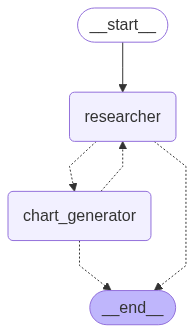

In [81]:
workflow.compile()

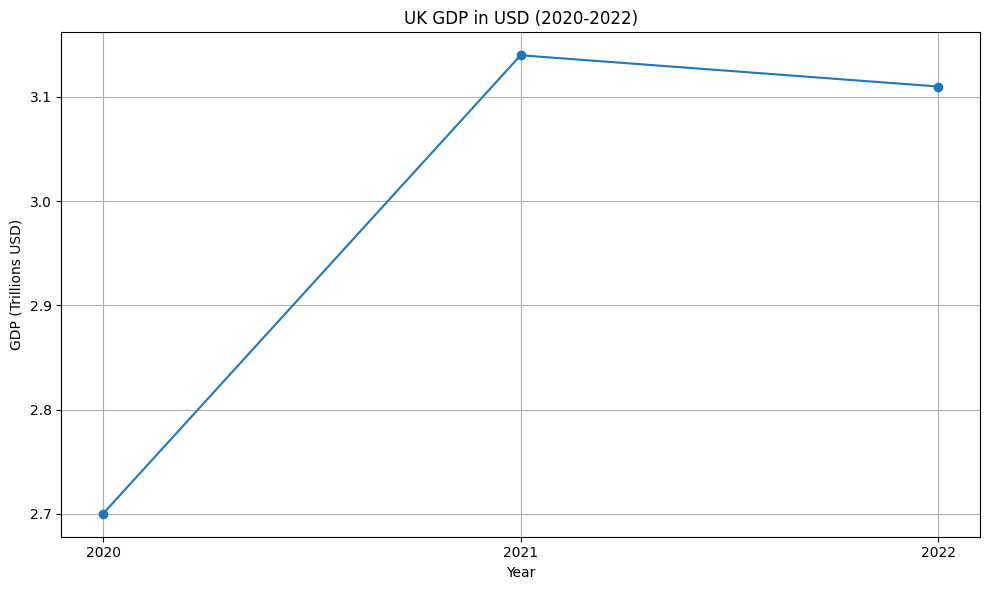

{'messages': [HumanMessage(content="get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='9101decd-987d-4132-a96f-0d6fd4378142'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_X3IRQato9uWiwS6woqCgKVf7', 'function': {'arguments': '{"query":"UK GDP 2021 2022 2023"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 199, 'total_tokens': 226, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-Bn73jDBNa3UX7ocq3BnCzUBRI92jX', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a4b53037-3310-4e85-8d8e-

In [88]:
app.invoke({"messages": [("user","get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.")],})

code="""import matplotlib.pyplot as plt\\n\\n# Data for the UK GDP over the past 3 years\\nyears = [2019, 2020, 2021]\\ngdp_values = [2851.41, 2697.81, 3141.51]  # in billion $ \\n\\ndef create_line_chart(years, gdp_values):\\n    plt.figure(figsize=(10, 6))\\n    plt.plot(years, gdp_values, marker=\'o\', color=\'b\', linestyle=\'-\', linewidth=2)\\n    plt.title(\'UK GDP Over the Past 3 Years\')\\n    plt.xlabel(\'Year\')\\n    plt.ylabel(\'GDP (in billion $)\')\\n    plt.grid(True)\\n    plt.tight_layout()\\n    plt.show()"""

In [164]:
code="""import matplotlib.pyplot as plt\\n\\n# Data for the UK GDP over the past 3 years\\nyears = [2019, 2020, 2021]\\ngdp_values = [2851.41, 2697.81, 3141.51]  # in billion $ \\n\\ndef create_line_chart(years, gdp_values):\\n    plt.figure(figsize=(10, 6))\\n    plt.plot(years, gdp_values, marker=\'o\', color=\'b\', linestyle=\'-\', linewidth=2)\\n    plt.title(\'UK GDP Over the Past 3 Years\')\\n    plt.xlabel(\'Year\')\\n    plt.ylabel(\'GDP (in billion $)\')\\n    plt.grid(True)\\n    plt.tight_layout()\\n    plt.show()"""

In [163]:
print("""import matplotlib.pyplot as plt\\n\\n# Data for the UK GDP over the past 3 years\\nyears = [2019, 2020, 2021]\\ngdp_values = [2851.41, 2697.81, 3141.51]  # in billion $ \\n\\ndef create_line_chart(years, gdp_values):\\n    plt.figure(figsize=(10, 6))\\n    plt.plot(years, gdp_values, marker=\'o\', color=\'b\', linestyle=\'-\', linewidth=2)\\n    plt.title(\'UK GDP Over the Past 3 Years\')\\n    plt.xlabel(\'Year\')\\n    plt.ylabel(\'GDP (in billion $)\')\\n    plt.grid(True)\\n    plt.tight_layout()\\n    plt.show()""")

import matplotlib.pyplot as plt\n\n# Data for the UK GDP over the past 3 years\nyears = [2019, 2020, 2021]\ngdp_values = [2851.41, 2697.81, 3141.51]  # in billion $ \n\ndef create_line_chart(years, gdp_values):\n    plt.figure(figsize=(10, 6))\n    plt.plot(years, gdp_values, marker='o', color='b', linestyle='-', linewidth=2)\n    plt.title('UK GDP Over the Past 3 Years')\n    plt.xlabel('Year')\n    plt.ylabel('GDP (in billion $)')\n    plt.grid(True)\n    plt.tight_layout()\n    plt.show()
